# Prey Predator Lab Notebook

(to edit this notebook and the associated python files, `git checkout` the corresponding commit by its hash, eg. `git checkout 422024d`)

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 11/Mar/2020 08:48

# Prey Predator dynamics on SD and ABM

On this notebook, we'll explore and visualize how P&P behave both in an Lotka-Volterra formalism, as in an agent-based one.

In [2]:
%%capture
%matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
from prey_predator_sd import run
from prey_predator_abm import run

In [3]:
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f9efc0ef1d0>, <cadCAD.configuration.Configuration object at 0x7f9efc0efdd0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f9efc0ef1d0>, <cadCAD.configuration.Configuration object at 0x7f9efc0efdd0>]
Execution in 72.7s


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


### System Dynamics - Lotka-Volterra

This is the standard introductory model for Prey-Predator interactions and dynamical systems in general. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Prey}&=\alpha * Prey-\beta * Prey * Predators,\\{\frac {d}{dt}Predators}&=\delta * Prey * Predators-\gamma * Predators,\end{aligned}

Where $\alpha$ and $\gamma$  are the prey growth rate and predator elimination rate, and $\delta$ and $\gamma$ are interaction factors between preys and predators.

The most promenient feature of it is the existence, depending on the choice of parameters, of an repeteable cycle around an fixed point which creates an dynamical equilibrium between the number of preys and predators on an system.

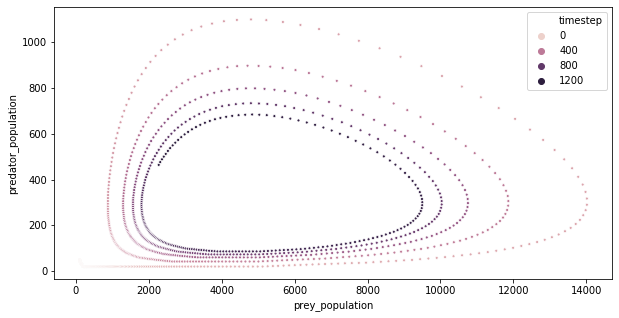

In [4]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=experiments.dataset[0],
                x='prey_population',
                y='predator_population',
                hue='timestep',
                marker='.')
plt.show()

### Agent-based modelling

There are a lot of possible ABMs for any given phenomenon. The beauty of cadCAD is that it'll allow you to put, modify and remove simulation blocks and steps at will. 

For this demo, we'll adopt an model based on an grid world, on which preys and predators do the following steps on each phase of their discrete and numerical lifes:

1. (before anything) Food is grown on every site.
2. All agents digests some of the food on their stomach and olden themselves.
3. All agents move or not to an available random neighboring location.
4. The agents reproduce themselves if there is an available partner nearby
5. The prey agents feed on the available food
6. The predator agents hunts the nearby preys
7. All old enough agents die

There is an innerent stochastic nature on this model, and every time that you run it, we'll have an completely different simulation for the same parameters. But we can see that there is sort of an random equilibrium that converges to the dynamical equilibrium which we presented on the dynamical simulation.

There is an bonus that ABMs can contain an very dense set of informations to which analyse. We'll plot only the most obvious ones, but the world is yours if you want to trace the network relations between the agents, or the geospatial statistics around the ABM.

In [5]:
agent_ds = experiments.dataset[1].agents
site_ds = experiments.dataset[1].sites
timesteps = experiments.dataset[1].timestep

# Get metrics
prey_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'prey']))
predator_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'predator']))

food_at_sites = site_ds.map(lambda s: s.sum())
food_at_prey = agent_ds.map(lambda s: sum([agent['food'] for agent in s.values() if agent['type'] == 'prey']))
food_at_predators = agent_ds.map(lambda s: sum([agent['food'] for agent in s.values() if agent['type'] == 'predator']))

median_site_food = site_ds.map(lambda s: np.median(s)) 
median_prey_food = agent_ds.map(lambda s: np.median([agent['food'] for agent in s.values() if agent['type'] == 'prey']))
median_predator_food = agent_ds.map(lambda s: np.median([agent['food'] for agent in s.values() if agent['type'] == 'predator']))

prey_median_age = agent_ds.map(lambda s: np.median([agent['age'] for agent in s.values() if agent['type'] == 'prey']))
predator_median_age = agent_ds.map(lambda s: np.median([agent['age'] for agent in s.values() if agent['type'] == 'predator']))

# Create an analysis dataset
data = (pd.DataFrame({'timestep': timesteps,
                      'prey_count': prey_count,
                      'predator_count': predator_count,
                      'food_at_sites': food_at_sites,
                      'food_at_prey': food_at_prey,
                      'food_at_predators': food_at_predators,
                      'median_site_food': median_site_food,
                      'median_prey_food': median_prey_food,
                      'median_predator_food': median_predator_food,
                      'prey_median_age': prey_median_age,
                      'predator_median_age': predator_median_age})       
       )

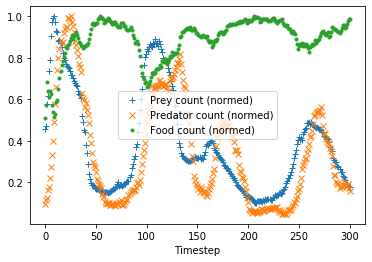

In [6]:
# Plot an time-series of it.
plt.plot(timesteps,
         prey_count / prey_count.max(),
         '+',
         color='C0',
         label='Prey count (normed)')
plt.plot(timesteps,
         predator_count / predator_count.max(),
         'x',
         color='C1',
         label='Predator count (normed)')
plt.plot(timesteps,
         food_at_sites / food_at_sites.max(),
         '.',
         color='C2', 
         label='Food count (normed)')
plt.xlabel('Timestep')
plt.legend()
plt.show()

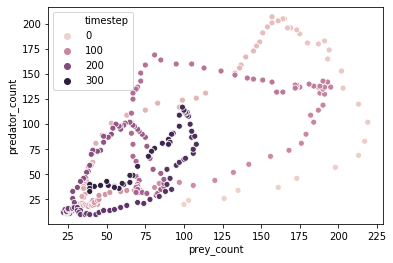

In [7]:
sns.scatterplot(data=data,
                x='prey_count',
                y='predator_count',
                hue='timestep')
plt.show()

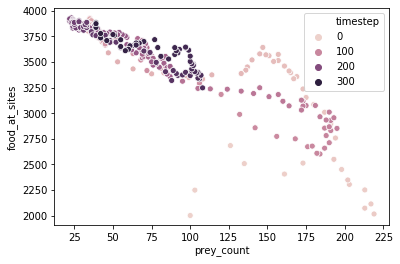

In [8]:
sns.scatterplot(data=data,
                x='prey_count',
                y='food_at_sites',
                hue='timestep')
plt.show()

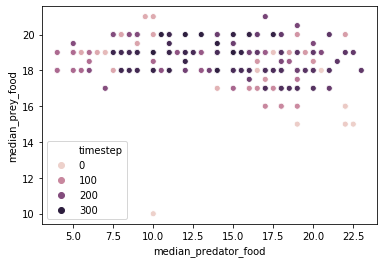

In [9]:
sns.scatterplot(data=data,
                x='median_predator_food',
                y='median_prey_food',
                hue='timestep')
plt.show()

In [ ]:
sns.pairplot(data=data, 
             diag_kind='kde', 
             markers='+')
plt.show()